# ConvNeXt V2 — 6-Class Chest X-Ray Classification

Dataset: COVID-19, Bacterial Pneumonia, Normal, Tuberculosis (6 classes)

In [1]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)
from concurrent.futures import ThreadPoolExecutor
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = Path(r"/kaggle/input/")

# Recursively search for a folder by name anywhere under base
def find_folder(base, folder_name, max_depth=5):
    base = Path(base)
    def _search(current, depth):
        if depth == 0:
            return None
        try:
            for entry in current.iterdir():
                if not entry.is_dir():
                    continue
                if entry.name == folder_name:
                    return entry
                result = _search(entry, depth - 1)
                if result:
                    return result
        except PermissionError:
            pass
        return None
    result = _search(base, max_depth)
    if result is None:
        raise FileNotFoundError(
            f"Could not find folder '{folder_name}' anywhere under {base}"
        )
    return result

covid_19   = find_folder(dataset, "COVID-19_Radiography_Dataset")
chest_xray = find_folder(dataset, "chest_xray")
tb_chest   = find_folder(dataset, "TB_Chest_Radiography_Database")

print(f"covid_19   = {covid_19}")
print(f"chest_xray = {chest_xray}")
print(f"tb_chest   = {tb_chest}")

covid_19   = /kaggle/input/datasets/tawsifurrahman/covid19-radiography-database/COVID-19_Radiography_Dataset
chest_xray = /kaggle/input/datasets/paultimothymooney/chest-xray-pneumonia/chest_xray
tb_chest   = /kaggle/input/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database


## Data Loading

In [4]:
class_mapping = defaultdict(list)

def append_file_names(directory, cls_name):
    """Append image file names from a directory to the class mapping."""
    directory = Path(directory)
    for f_name in os.listdir(directory):
        if f_name.lower().endswith((".jpeg", ".jpg", ".png")):
            class_mapping[cls_name].append(str(directory / f_name))

# COVID-19 dataset: each subfolder (COVID, Lung_Opacity, Normal, Viral Pneumonia)
# has an 'images' subdirectory
for covid19_class in [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]:
    images_dir = covid_19 / covid19_class / 'images'
    if images_dir.exists():
        append_file_names(images_dir, covid19_class)
    else:
        # Some versions store images directly in the class folder
        append_file_names(covid_19 / covid19_class, covid19_class)

# Chest X-Ray dataset: only Bacterial Pneumonia (bacteria keyword in filename)
pneumonia_dirs = [chest_xray / "train" / "PNEUMONIA",
                  chest_xray / "test"  / "PNEUMONIA",
                  chest_xray / "val"   / "PNEUMONIA"]
for source_dir in pneumonia_dirs:
    if not source_dir.exists():
        print(f"Skipping (not found): {source_dir}")
        continue
    for filename in os.listdir(source_dir):
        if filename.lower().endswith((".jpeg", ".jpg", ".png")):
            if "bacteria" in filename.lower():
                class_mapping["Bacterial Pneumonia"].append(str(source_dir / filename))

# TB dataset
tb_dir = tb_chest / "Tuberculosis"
if tb_dir.exists():
    append_file_names(tb_dir, "Tuberculosis")
else:
    print(f"TB directory not found: {tb_dir}")

print("Classes found:", list(class_mapping.keys()))
print("Counts:", {k: len(v) for k, v in class_mapping.items()})

class_names = list(class_mapping.keys())
image_paths = []
labels = []

for class_name, file_paths in class_mapping.items():
    for file_path in tqdm(file_paths, desc=f"Processing {class_name}"):
        image_paths.append(file_path)
        labels.append(class_name)

Classes found: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID', 'Bacterial Pneumonia', 'Tuberculosis']
Counts: {'Normal': 10192, 'Lung_Opacity': 6012, 'Viral Pneumonia': 1345, 'COVID': 3616, 'Bacterial Pneumonia': 2780, 'Tuberculosis': 700}


Processing Tuberculosis: 100%|██████████| 700/700 [00:00<00:00, 1983792.43it/s]


## Train/Val/Test Split

In [5]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.1, random_state=42, stratify=labels_encoded
)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths, remaining_labels, test_size=0.1111, random_state=42, stratify=remaining_labels
)

total_samples = len(labels_encoded)
print(f"Train: {len(train_paths)} ({len(train_paths)/total_samples*100:.2f}%)")
print(f"Val:   {len(val_paths)} ({len(val_paths)/total_samples*100:.2f}%)")
print(f"Test:  {len(test_paths)} ({len(test_paths)/total_samples*100:.2f}%)")

Train: 19715 (80.00%)
Val:   2465 (10.00%)
Test:  2465 (10.00%)


## Dataset & DataLoaders

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img)
        transformed_img = self.transform(pil_img)
        label = self.img_labels[index]
        return transformed_img, label

In [7]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

## ConvNeXt V2 Model

In [8]:
# pip install timm if not installed
import timm

model = timm.create_model('convnextv2_base', pretrained=True, num_classes=num_classes)
model = model.to(device)
summary(model, (1, 3, 224, 224))

model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

Layer (type:depth-idx)                                       Output Shape              Param #
ConvNeXt                                                     [1, 6]                    --
├─Sequential: 1-1                                            [1, 128, 56, 56]          --
│    └─Conv2d: 2-1                                           [1, 128, 56, 56]          6,272
│    └─LayerNorm2d: 2-2                                      [1, 128, 56, 56]          256
├─Sequential: 1-2                                            [1, 1024, 7, 7]           --
│    └─ConvNeXtStage: 2-3                                    [1, 128, 56, 56]          --
│    │    └─Identity: 3-1                                    [1, 128, 56, 56]          --
│    │    └─Sequential: 3-2                                  [1, 128, 56, 56]          418,176
│    └─ConvNeXtStage: 2-4                                    [1, 256, 28, 28]          --
│    │    └─Sequential: 3-3                                  [1, 256, 28, 28]         

## Metrics Function

In [9]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)
    auc_scores = []
    for class_idx in range(y_pred.shape[1]):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)
    auc_avg = np.mean(auc_scores)
    return {
        "loss": loss, "accuracy": accuracy, "precision": precision,
        "recall": recall, "f1_score": f1, "specificity": specificity,
        "sensitivity": sensitivity, "mcc": mcc, "auc": auc_avg,
    }

## Training

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {m: [] for m in metric_names}
val_metrics_history = {m: [] for m in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for data, targets in tqdm(train_loader, desc=f"Training - Epoch [{epoch+1}/{num_epochs}]"):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    total_training_time += end_time - start_time

    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    for m in metric_names:
        train_metrics_history[m].append(train_metrics[m])
    line = "Train - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(line)

    # Validation
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    val_start = time.time()
    with torch.no_grad():
        for data, targets in tqdm(val_loader, desc=f"Validation - Epoch [{epoch+1}/{num_epochs}]"):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    total_validation_time += time.time() - val_start

    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    for m in metric_names:
        val_metrics_history[m].append(val_metrics[m])
    line = "Val   - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(line)

    scheduler.step()

print(f"\nTotal Training Time: {str(timedelta(seconds=int(total_training_time)))}")
print(f"Total Validation Time: {str(timedelta(seconds=int(total_validation_time)))}")

Training - Epoch [1/25]: 100%|██████████| 1233/1233 [18:39<00:00,  1.10it/s]


Train - loss: 0.2576, accuracy: 0.9100, precision: 0.9108, recall: 0.9100, f1_score: 0.9095, specificity: 0.9685, sensitivity: 0.9935, mcc: 0.8764, auc: 0.9805


Training - Epoch [2/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.1001, accuracy: 0.9664, precision: 0.9664, recall: 0.9664, f1_score: 0.9663, specificity: 0.9969, sensitivity: 0.9997, mcc: 0.9540, auc: 0.9968


Validation - Epoch [2/25]: 100%|██████████| 155/155 [00:19<00:00,  7.83it/s]


Val   - loss: 0.1231, accuracy: 0.9627, precision: 0.9631, recall: 0.9627, f1_score: 0.9625, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9491, auc: 0.9962


Training - Epoch [3/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0578, accuracy: 0.9803, precision: 0.9803, recall: 0.9803, f1_score: 0.9803, specificity: 0.9973, sensitivity: 0.9996, mcc: 0.9731, auc: 0.9988


Validation - Epoch [3/25]: 100%|██████████| 155/155 [00:19<00:00,  7.82it/s]


Val   - loss: 0.1177, accuracy: 0.9651, precision: 0.9652, recall: 0.9651, f1_score: 0.9650, specificity: 0.9892, sensitivity: 1.0000, mcc: 0.9523, auc: 0.9964


Training - Epoch [4/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0283, accuracy: 0.9910, precision: 0.9910, recall: 0.9910, f1_score: 0.9910, specificity: 0.9996, sensitivity: 1.0000, mcc: 0.9877, auc: 0.9996


Validation - Epoch [4/25]: 100%|██████████| 155/155 [00:19<00:00,  7.83it/s]


Val   - loss: 0.1419, accuracy: 0.9598, precision: 0.9600, recall: 0.9598, f1_score: 0.9598, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9450, auc: 0.9964


Training - Epoch [5/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0181, accuracy: 0.9943, precision: 0.9943, recall: 0.9943, f1_score: 0.9943, specificity: 0.9982, sensitivity: 0.9998, mcc: 0.9922, auc: 0.9999


Validation - Epoch [5/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.1571, accuracy: 0.9639, precision: 0.9641, recall: 0.9639, f1_score: 0.9640, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9507, auc: 0.9966


Training - Epoch [6/25]: 100%|██████████| 1233/1233 [18:36<00:00,  1.10it/s]


Train - loss: 0.0138, accuracy: 0.9959, precision: 0.9959, recall: 0.9959, f1_score: 0.9959, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9945, auc: 0.9999


Validation - Epoch [6/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.2193, accuracy: 0.9606, precision: 0.9619, recall: 0.9606, f1_score: 0.9603, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9467, auc: 0.9954


Training - Epoch [7/25]: 100%|██████████| 1233/1233 [18:36<00:00,  1.10it/s]


Train - loss: 0.0127, accuracy: 0.9958, precision: 0.9958, recall: 0.9958, f1_score: 0.9958, specificity: 0.9951, sensitivity: 0.9995, mcc: 0.9943, auc: 0.9999


Validation - Epoch [7/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.1864, accuracy: 0.9590, precision: 0.9591, recall: 0.9590, f1_score: 0.9591, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9440, auc: 0.9962


Training - Epoch [8/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.10it/s]


Train - loss: 0.0076, accuracy: 0.9973, precision: 0.9973, recall: 0.9973, f1_score: 0.9973, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9963, auc: 1.0000


Validation - Epoch [8/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.2080, accuracy: 0.9611, precision: 0.9614, recall: 0.9611, f1_score: 0.9609, specificity: 0.9964, sensitivity: 1.0000, mcc: 0.9468, auc: 0.9963


Training - Epoch [9/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0063, accuracy: 0.9980, precision: 0.9980, recall: 0.9980, f1_score: 0.9980, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9972, auc: 1.0000


Validation - Epoch [9/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.1909, accuracy: 0.9651, precision: 0.9651, recall: 0.9651, f1_score: 0.9650, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9523, auc: 0.9964


Training - Epoch [10/25]: 100%|██████████| 1233/1233 [18:36<00:00,  1.10it/s]


Train - loss: 0.0084, accuracy: 0.9975, precision: 0.9975, recall: 0.9975, f1_score: 0.9975, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9966, auc: 1.0000


Validation - Epoch [10/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.1835, accuracy: 0.9639, precision: 0.9641, recall: 0.9639, f1_score: 0.9637, specificity: 0.9964, sensitivity: 1.0000, mcc: 0.9507, auc: 0.9964


Training - Epoch [11/25]: 100%|██████████| 1233/1233 [18:36<00:00,  1.10it/s]


Train - loss: 0.0110, accuracy: 0.9964, precision: 0.9964, recall: 0.9964, f1_score: 0.9964, specificity: 0.9978, sensitivity: 0.9997, mcc: 0.9951, auc: 1.0000


Validation - Epoch [11/25]: 100%|██████████| 155/155 [00:19<00:00,  7.83it/s]


Val   - loss: 0.2094, accuracy: 0.9627, precision: 0.9632, recall: 0.9627, f1_score: 0.9625, specificity: 0.9928, sensitivity: 1.0000, mcc: 0.9491, auc: 0.9966


Training - Epoch [12/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0055, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 0.9978, sensitivity: 0.9998, mcc: 0.9978, auc: 1.0000


Validation - Epoch [12/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.1801, accuracy: 0.9570, precision: 0.9570, recall: 0.9570, f1_score: 0.9570, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9412, auc: 0.9958


Training - Epoch [13/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.10it/s]


Train - loss: 0.0052, accuracy: 0.9983, precision: 0.9983, recall: 0.9983, f1_score: 0.9983, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9977, auc: 1.0000


Validation - Epoch [13/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.1976, accuracy: 0.9643, precision: 0.9644, recall: 0.9643, f1_score: 0.9642, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9512, auc: 0.9962


Training - Epoch [14/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0051, accuracy: 0.9982, precision: 0.9982, recall: 0.9982, f1_score: 0.9982, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9976, auc: 1.0000


Validation - Epoch [14/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.2357, accuracy: 0.9647, precision: 0.9654, recall: 0.9647, f1_score: 0.9645, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9520, auc: 0.9961


Training - Epoch [15/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0092, accuracy: 0.9967, precision: 0.9967, recall: 0.9967, f1_score: 0.9967, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9955, auc: 1.0000


Validation - Epoch [15/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.1979, accuracy: 0.9647, precision: 0.9651, recall: 0.9647, f1_score: 0.9646, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9519, auc: 0.9962


Training - Epoch [16/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0023, accuracy: 0.9992, precision: 0.9992, recall: 0.9992, f1_score: 0.9992, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9990, auc: 1.0000


Validation - Epoch [16/25]: 100%|██████████| 155/155 [00:19<00:00,  7.85it/s]


Val   - loss: 0.2409, accuracy: 0.9631, precision: 0.9639, recall: 0.9631, f1_score: 0.9629, specificity: 0.9964, sensitivity: 1.0000, mcc: 0.9498, auc: 0.9964


Training - Epoch [17/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0047, accuracy: 0.9983, precision: 0.9983, recall: 0.9983, f1_score: 0.9983, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9976, auc: 1.0000


Validation - Epoch [17/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.1959, accuracy: 0.9623, precision: 0.9624, recall: 0.9623, f1_score: 0.9623, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9485, auc: 0.9966


Training - Epoch [18/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0042, accuracy: 0.9986, precision: 0.9986, recall: 0.9986, f1_score: 0.9986, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9981, auc: 1.0000


Validation - Epoch [18/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.2311, accuracy: 0.9655, precision: 0.9655, recall: 0.9655, f1_score: 0.9655, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9529, auc: 0.9958


Training - Epoch [19/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0075, accuracy: 0.9979, precision: 0.9979, recall: 0.9979, f1_score: 0.9979, specificity: 0.9973, sensitivity: 0.9997, mcc: 0.9972, auc: 1.0000


Validation - Epoch [19/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.2175, accuracy: 0.9635, precision: 0.9636, recall: 0.9635, f1_score: 0.9634, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9501, auc: 0.9959


Training - Epoch [20/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0001, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validation - Epoch [20/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.2452, accuracy: 0.9635, precision: 0.9636, recall: 0.9635, f1_score: 0.9634, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9501, auc: 0.9958


Training - Epoch [21/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.11it/s]


Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validation - Epoch [21/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.2614, accuracy: 0.9643, precision: 0.9644, recall: 0.9643, f1_score: 0.9642, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9512, auc: 0.9957


Training - Epoch [22/25]: 100%|██████████| 1233/1233 [18:34<00:00,  1.11it/s]


Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validation - Epoch [22/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.2758, accuracy: 0.9639, precision: 0.9640, recall: 0.9639, f1_score: 0.9638, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9506, auc: 0.9955


Training - Epoch [23/25]: 100%|██████████| 1233/1233 [18:35<00:00,  1.10it/s]


Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validation - Epoch [23/25]: 100%|██████████| 155/155 [00:19<00:00,  7.83it/s]


Val   - loss: 0.2900, accuracy: 0.9647, precision: 0.9648, recall: 0.9647, f1_score: 0.9646, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9518, auc: 0.9954


Training - Epoch [24/25]: 100%|██████████| 1233/1233 [18:36<00:00,  1.10it/s]


Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validation - Epoch [24/25]: 100%|██████████| 155/155 [00:19<00:00,  7.85it/s]


Val   - loss: 0.3023, accuracy: 0.9643, precision: 0.9644, recall: 0.9643, f1_score: 0.9642, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9512, auc: 0.9953


Training - Epoch [25/25]: 100%|██████████| 1233/1233 [18:36<00:00,  1.10it/s]


Train - loss: 0.0000, accuracy: 1.0000, precision: 1.0000, recall: 1.0000, f1_score: 1.0000, specificity: 1.0000, sensitivity: 1.0000, mcc: 1.0000, auc: 1.0000


Validation - Epoch [25/25]: 100%|██████████| 155/155 [00:19<00:00,  7.84it/s]


Val   - loss: 0.3165, accuracy: 0.9647, precision: 0.9648, recall: 0.9647, f1_score: 0.9646, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9518, auc: 0.9951

Total Training Time: 7:44:57
Total Validation Time: 0:08:16


## Plot Metrics

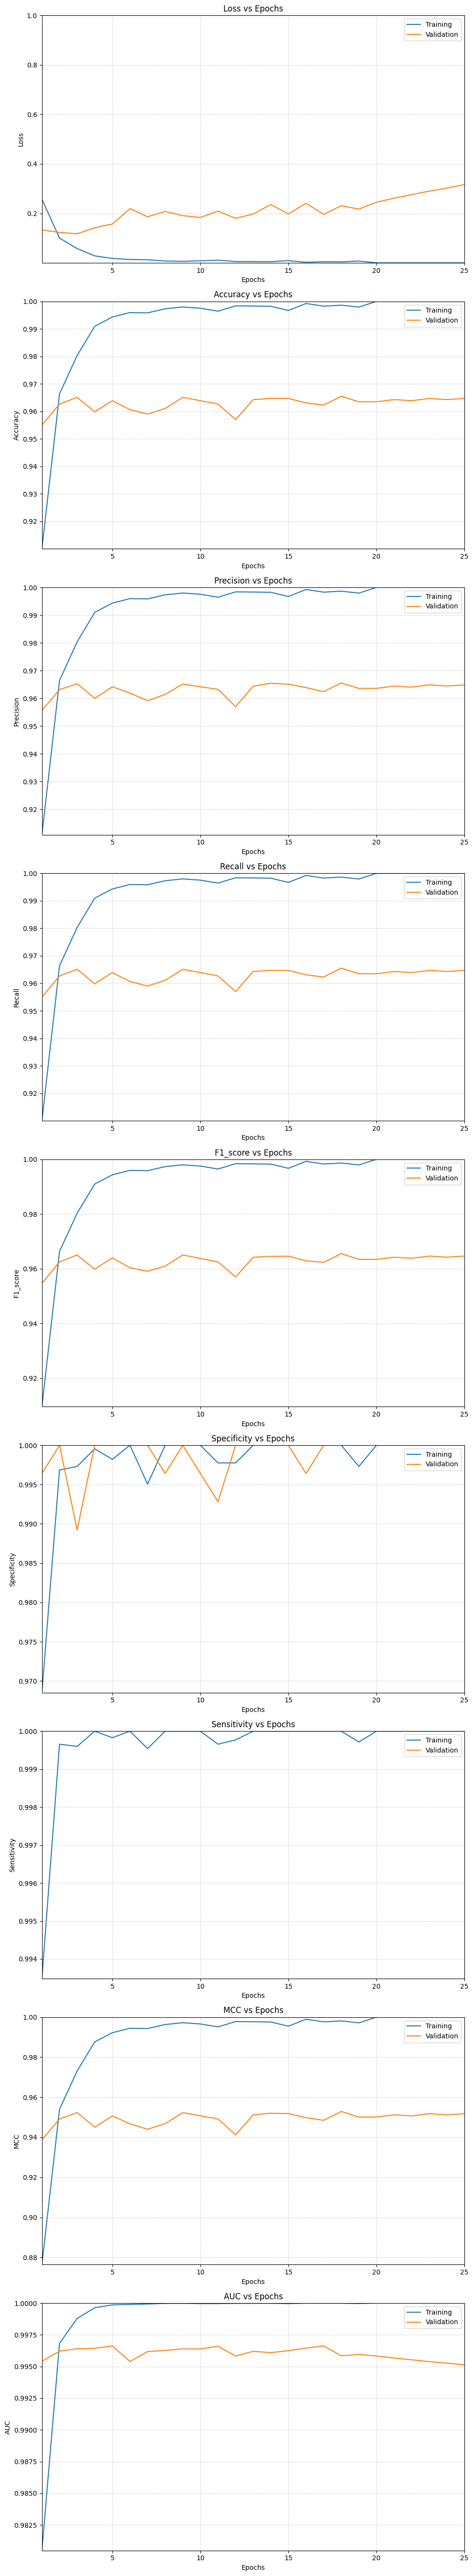

In [11]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])
    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)
    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]
        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")
        label = metric_name.upper() if metric_name in ("auc", "mcc") else metric_name.capitalize()
        ax.set_ylabel(label)
        ax.set_title(f"{label} vs Epochs")
        max_m = max(max(train_metric), max(val_metric))
        min_m = min(min(train_metric), min(val_metric))
        ax.set_ylim(min_m if min_m < 0 or max_m > 1 else min_m, math.ceil(max_m))
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)
    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

## Test Evaluation

In [12]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, targets in tqdm(test_loader, desc="Testing Model"):
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
print("Test Metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Testing Model: 100%|██████████| 155/155 [00:19<00:00,  7.79it/s]


Test Metrics:
  loss: 0.2817
  accuracy: 0.9631
  precision: 0.9630
  recall: 0.9631
  f1_score: 0.9630
  specificity: 1.0000
  sensitivity: 1.0000
  mcc: 0.9495
  auc: 0.9962


## Classification Report & Confusion Matrix

                     precision    recall  f1-score   support

Bacterial Pneumonia     1.0000    1.0000    1.0000       278
              COVID     0.9890    0.9890    0.9890       362
       Lung_Opacity     0.9405    0.9201    0.9302       601
             Normal     0.9534    0.9627    0.9580      1019
       Tuberculosis     1.0000    1.0000    1.0000        70
    Viral Pneumonia     0.9710    0.9926    0.9817       135

           accuracy                         0.9631      2465
          macro avg     0.9756    0.9774    0.9765      2465
       weighted avg     0.9630    0.9631    0.9630      2465

There were 91 errors in 2465 tests for an accuracy of  96.31%


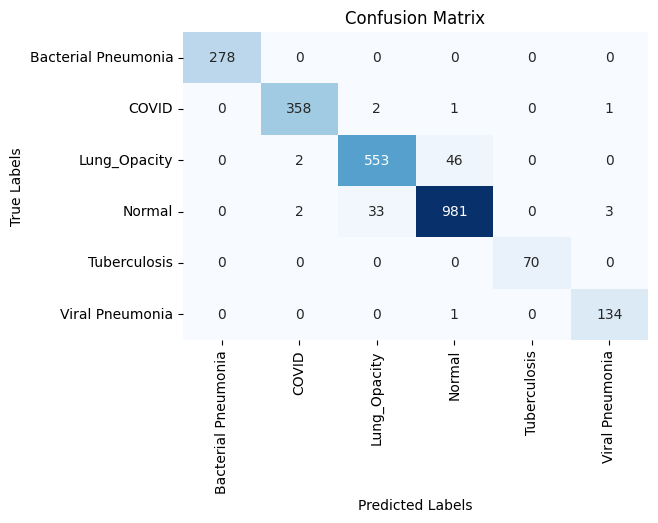

In [13]:
true_labels = np.array(all_targets).astype(int)
predicted_labels = np.argmax(np.array(all_predictions), axis=1).astype(int)
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)
print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}%')

conf_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    conf_matrix[t, p] += 1
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()